1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


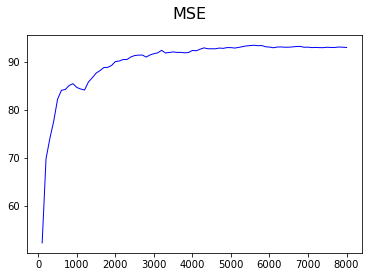

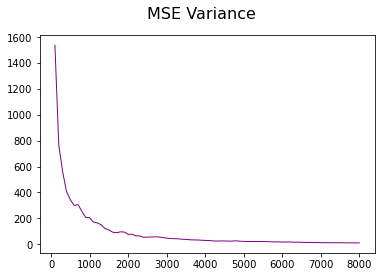

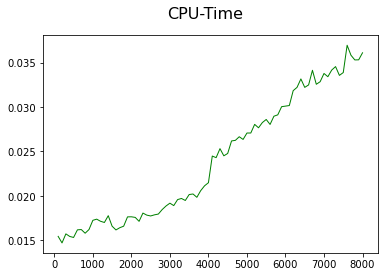

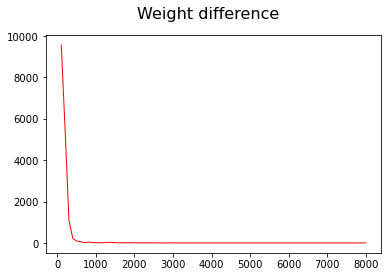

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.datasets import load_svmlight_file
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import random

SPACE_SIZE = 100
N_PERM = 30
FILE = "cpusmall_scale.txt"
# Load the data
X_train, y_train =  sklearn.datasets.load_svmlight_file(FILE)
# Create the regressor
reg = linear_model.LinearRegression()
num_rows, num_cols = X_train.shape
# Create needed variables
mse = []
N = []
time_cpu = []
weights = []
weight_old = [0]*num_cols

i_max = np.floor(num_rows/SPACE_SIZE)
i_max = int(i_max)

mse_av = [0]*(i_max-1)
cpu_av = [0]*(i_max-1)
weight_diff_av = [0]*(i_max-1)
mse_matrix = np.zeros([N_PERM, i_max-1]) #Rows: N_PERMS

# Number of permutations to smooth & variance
for j in range(1,N_PERM):
     
    shuffler = np.random.permutation(len(y_train))
    x = X_train[shuffler]
    y = y_train[shuffler]
    N = []
    # Incremental training     
    for i in range(1,i_max):

        t = time.time()
        X_train_samples = x[0:SPACE_SIZE*i]
        y_train_samples = y[0:SPACE_SIZE*i]
        reg.fit(X_train_samples, y_train_samples)
        y_predicted = reg.predict(X_train_samples)
        # Compute the Mean Squared Error        
        new_mse = [mean_squared_error(y_train_samples, y_predicted)]
        # Accumulate in the mse vector
        mse = np.concatenate((mse, new_mse))
        # Compute difference between previous weights and current
        weights = np.append(weights, mean_squared_error(weight_old, reg.coef_)) 
        weight_old = reg.coef_
        N = np.append(N, SPACE_SIZE*i)
        elapsed = time.time() - t
        time_cpu =  np.concatenate((time_cpu , [elapsed]))
        
    # Store the experiment/permutation in the matrix
    mse_matrix[j,:] = mse
    mse_av = mse_av + mse
    cpu_av = cpu_av + time_cpu
    weight_diff_av = weight_diff_av + weights
    weights = []
    weight_old = [0]*num_cols
    time_cpu = []
    mse = []
    print(j)
# Divide for the average parameters
mse_av = mse_av / N_PERM
cpu_av = cpu_av / N_PERM
weight_diff_av = weight_diff_av / N_PERM

# Compute the variance of the mse
mse_variance = np.zeros([i_max-1])
for i in range(1,N_PERM):
    mse_variance = mse_variance + (mse_av - mse_matrix[i,:])**2

mse_variance = mse_variance/N_PERM

# Plots
fig1 = plt.figure()
fig1.suptitle('MSE', fontsize=16)
plt.plot(N, mse_av, color='blue', linewidth=1)
fig2 = plt.figure()
fig2.suptitle('MSE Variance', fontsize=16)
plt.plot(N, mse_variance, color='purple', linewidth=1)
fig3 = plt.figure()
fig3.suptitle('CPU-Time', fontsize=16)
plt.plot(N, cpu_av, color='green', linewidth=1)
fig4 = plt.figure()
fig4.suptitle('Weight difference', fontsize=16)
plt.plot(N, weight_diff_av, color='red', linewidth=1)




0
1
2
3
4
5
6
7
8
9


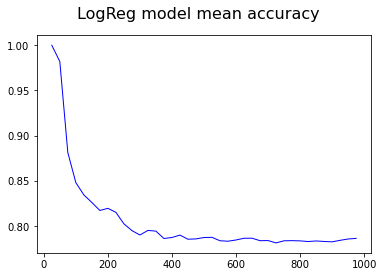

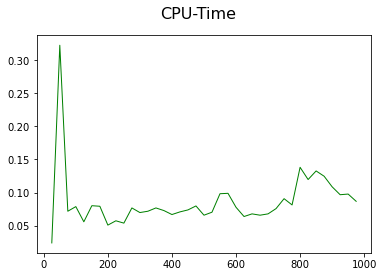

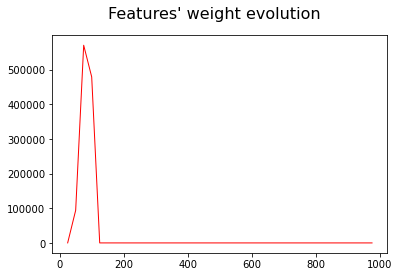

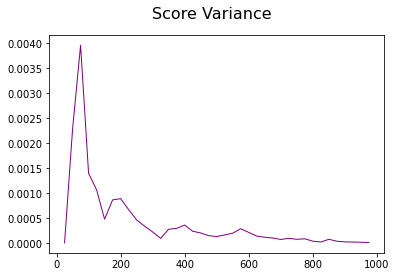

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn
import time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.datasets import load_svmlight_file
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import random

# Load Data
SPACE_SIZE = 25
X_train, y_train =  sklearn.datasets.load_svmlight_file("german.numer_scale.txt")
N_PERM = 10
num_rows, num_cols = X_train.shape
N_FEATURES = num_cols
# First shuffle of the data
shuffler = np.random.permutation(len(y_train))
X_train = X_train[shuffler]
y_train = y_train[shuffler]
# Create the classifier
clf = linear_model.LogisticRegression(penalty = 'none',max_iter = 10000)
# For the incremental training 
i_max = np.floor(num_rows/SPACE_SIZE)
i_max = int(i_max)
# Needed auxiliar variables
score = []
score_avg = [0]*(i_max-1)
acc_loss = []
acc_loss_avg = [0]*(i_max-1)
N = []
time_cpu_log = []
weights_log = []
weights_log_avg = [0]*(i_max-1)
weight_old_log = np.zeros(shape=(1, N_FEATURES))

weight = np.zeros(shape=(i_max, N_FEATURES))
weight_dif = []
weight_old_L = np.zeros(shape=(1, N_FEATURES))

score_matrix = np.zeros([N_PERM, i_max-1]) #Rows: N_PERMS

# Number of permutations to smooth & variance
for j in range(0,N_PERM):
    # Shuffle the data     
    shuffler = np.random.permutation(len(y_train))
    x = X_train[shuffler]
    y = y_train[shuffler]
    # Reset variables for next permutation      
    N = []
    time_cpu_log = []
    weight_dif = []
    for i in range(1,i_max):

        X_train_samples_log = x[0:SPACE_SIZE*i]
        y_train_samples_log = y[0:SPACE_SIZE*i]

        t = time.time()
        clf.fit(X_train_samples_log, y_train_samples_log)
        elapsed = time.time() - t
        # Compute the score and the error (1-score)
        new_score = clf.score(X_train_samples_log, y_train_samples_log)
        acc_loss = np.concatenate((acc_loss, [1-new_score]))
        score = np.concatenate((score, [new_score]))
        time_cpu_log =  np.concatenate((time_cpu_log , [elapsed]))

        N = np.concatenate((N, [SPACE_SIZE*i])) 
        weight[i][:] = clf.coef_

        weight_dif = np.concatenate((weight_dif, [mean_squared_error(weight_old_L, clf.coef_)])) 
        weight_old_L = clf.coef_

    score_matrix[j,:] = score
    score_avg = score_avg + score
    acc_loss_avg = acc_loss_avg + acc_loss
    weights_log_avg = weights_log_avg +  weight_dif
    
    score = []
    acc_loss = []
    
    weight_old_L = np.zeros(shape=(1, N_FEATURES))
    print(j)
# Compute the averages
score_avg = score_avg/N_PERM 
acc_loss_avg = acc_loss_avg/N_PERM
weights_log_avg = weights_log_avg/N_PERM
# Compute the variance
score_variance = np.zeros([i_max-1])
for p in range(0,N_PERM):
    score_variance = score_variance + (score_avg - score_matrix[p,:])**2
    
score_variance = score_variance / N_PERM 
# Plots
fig1_log = plt.figure()
fig1_log.suptitle('LogReg model mean accuracy', fontsize=16)
plt.plot(N, score_avg, color='blue', linewidth=1) 

fig2_log = plt.figure()
fig2_log.suptitle('CPU-Time', fontsize=16)
plt.plot(N, time_cpu_log, color='green', linewidth=1) 

fig3_log = plt.figure()
fig3_log.suptitle("Features' weight evolution", fontsize=16)
plt.plot(N, weights_log_avg, color='red', linewidth=1) 

fig4_log = plt.figure()
fig4_log.suptitle('Score Variance', fontsize=16)
plt.plot(N, score_variance, color='purple', linewidth=1)

In [ ]:
num_rows

In [ ]:
num_cols

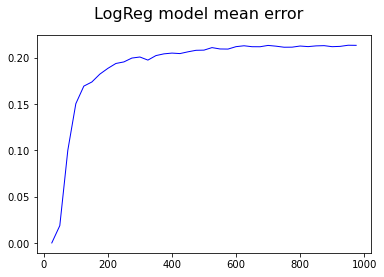

In [8]:
fig1_log = plt.figure()
fig1_log.suptitle('LogReg model mean error', fontsize=16)
plt.plot(N, 1-score_avg, color='blue', linewidth=1) 